In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sshi\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### First create a simple train and test set

In [2]:
# create a sine wave
n_samples = int(1e3)
min_x = 0
max_x = 100
x = np.linspace(min_x, max_x, n_samples)
sinx = np.sin(x)
# add a Gaussian noise to it
noise_m = 1
noise_sd = 0.5
noise = np.random.normal(noise_m, noise_sd, n_samples)
smooth = sinx+noise_m
y = sinx + noise

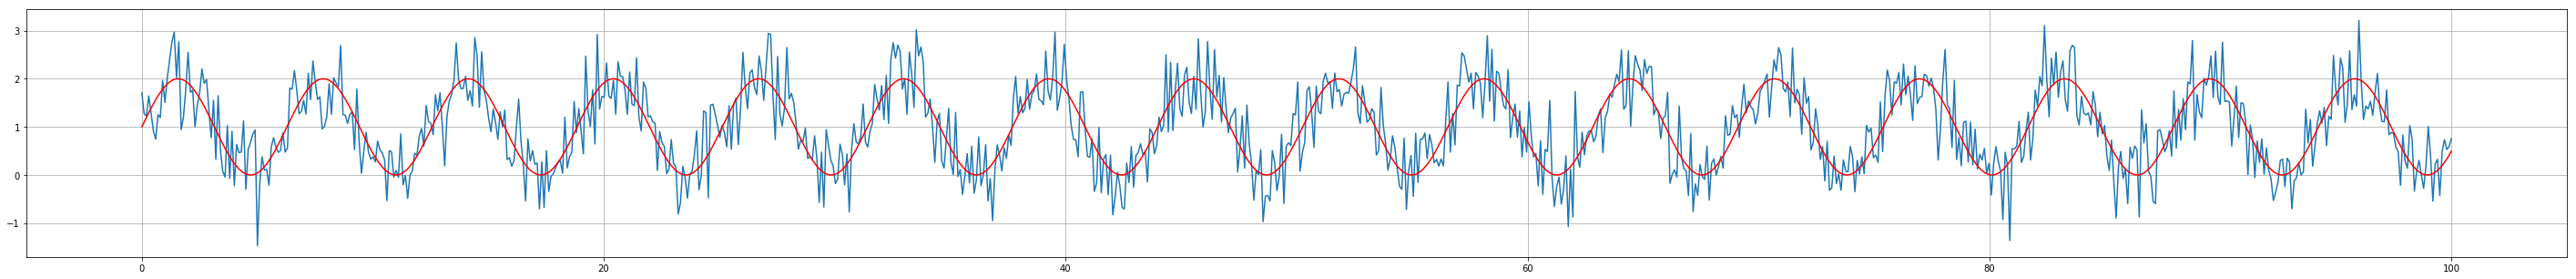

In [3]:
# plot
plt.figure(figsize=(50,5))
plt.plot(x, y, x, sinx+noise_m, 'r')
plt.grid('on')

In [4]:
def segment(X, length):
    ''' 
    segment a given list of moments to list of chunks each with size length 
    to do: try to implement overlap option
    '''
    n_segs = len(X)//length
#     return [X[i+(i+1)*length-op:i+(i+2)*length-op] for i in range(0, n_segs)]
    return [X[i*length:(i+1)*length] for i in range(0, n_segs)]

In [21]:
# split it to train and test
slice_ind = int(n_samples*0.8)
train_x, train_y, test_x, test_y, smooth_y_train, smooth_y_test = x[:slice_ind], y[:slice_ind], x[slice_ind:], y[slice_ind:], smooth[:slice_ind], smooth[slice_ind:]
train_n, test_n = len(train_x), len(test_x)

# chunk it to each small window
seq_len = 3
# note train_y is actually the value
train_y = np.array(segment(train_y, seq_len))
train_y = train_y.reshape(-1, seq_len, 1)

In [6]:
train_y.shape

(266, 3, 1)

#### Build model

In [7]:
%%time
tf.reset_default_graph()
state_size = 100
lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.)

X = tf.placeholder(tf.float64, [None, seq_len, 1])#, name = 'input')
Y = tf.placeholder(tf.float64, [None, seq_len, 1])#, name = 'output')

# dynamic rnn
output, last_states = tf.nn.dynamic_rnn(inputs=X, cell=lstm_cell, dtype=tf.float64)
pred = tf.contrib.layers.fully_connected(inputs=output, num_outputs=1)

# loss
label = np.roll(train_y, 1)
loss = tf.reduce_sum(tf.pow(pred-label, 2))/(2*n_samples)

# optimzier
opt = tf.train.AdamOptimizer().minimize(loss)


# session
sess = tf.Session()
# Initializing the variables
sess.run(tf.global_variables_initializer())

# iterate
for i in range(1000):
    print(i+1, end='\r')
    p, l, _ = sess.run([pred, loss, opt], feed_dict={X: train_y, Y: label})

Wall time: 19.4 s


In [8]:
p.shape

(266, 3, 1)

In [9]:
label.shape

(266, 3, 1)

In [10]:
train_x.shape

(800,)

In [20]:
smooth_y_train.shape

(200,)

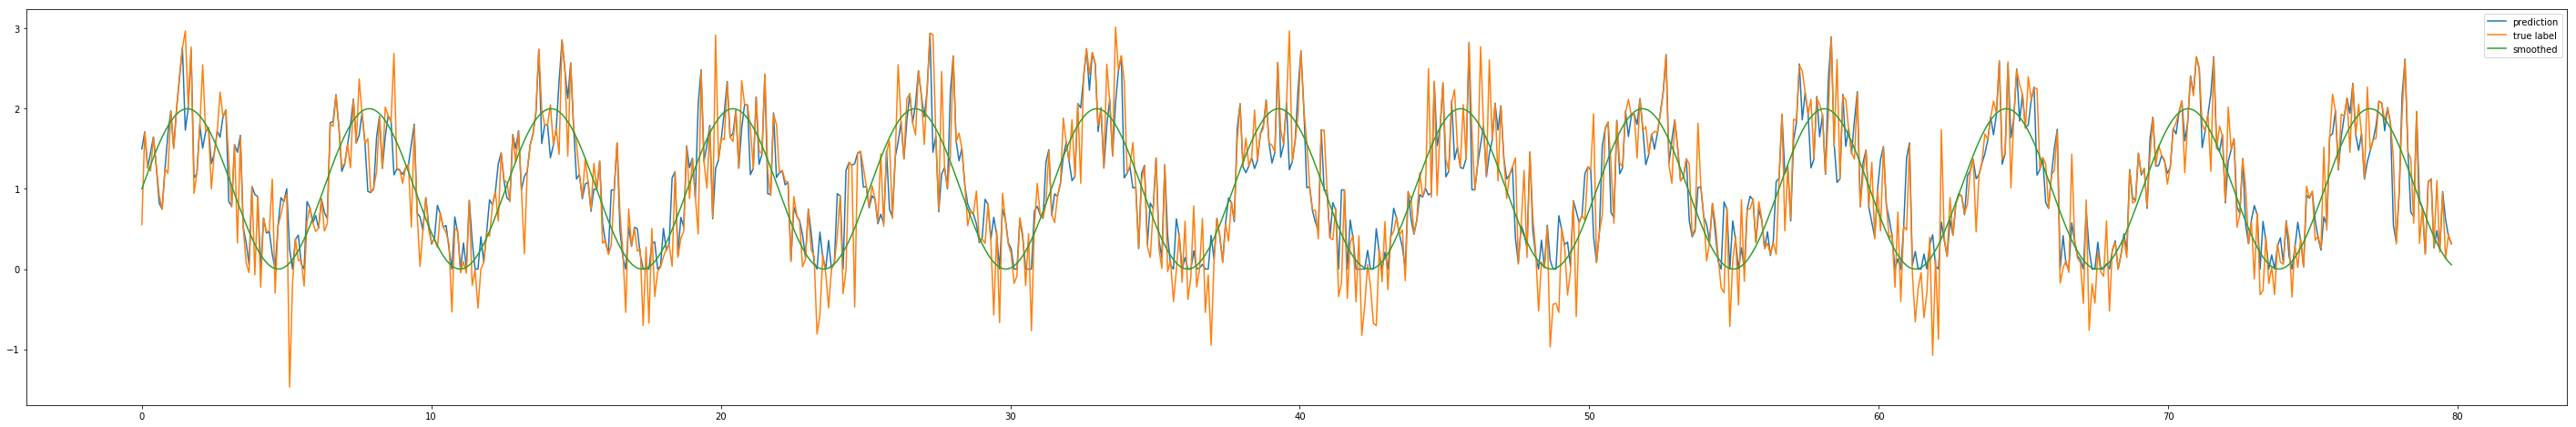

In [23]:
plt.figure(figsize=(50,8))
plt.plot(train_x[:-2], p.reshape(-1), train_x[:-2], label.reshape(-1), train_x[:-2], smooth_y_train.reshape(-1)[:-2])
plt.legend(['prediction', 'true label', 'smoothed'])